<a href="https://colab.research.google.com/github/camilealheiro/inicializacao-e-quebra-de-empates-da-qtable/blob/main/Tema_9_Inicializa%C3%A7%C3%A3o_e_Quebra_de_Empates_da_Q_Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicialização e Quebra de Empates da Q-Table (principalmente em ambientes estocásticos)

## Imports

In [ ]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium   # conferir se precisa

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [ ]:
import time
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from util.plot import plot_result
from util.qtable_helper import record_video_qtable, evaluate_qtable_policy
from util.notebook import display_videos_from_path
from util.experiments import repeated_exec
from util.plot import plot_multiple_results

import envs

In [ ]:
# define se os algoritmos vão imprimir dados do treinamento
VERBOSE = True

## Monte Carlo V2

In [ ]:
def choose_action(Q, state, num_actions, epsilon, random_tie_break=False):
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        # Encontrar os índices das ações com maior valor Q
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]

        if random_tie_break:
            return np.random.choice(best_actions)
        else:
            return best_actions[0]

In [ ]:
# Algoritmo Monte-Carlo de Controle, variante "toda-visita".
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_montecarlo2(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, init_type="zero", random_tie_break=False, max_steps_per_episode=None):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zero,
    # usar o estado como índice das linhas e a ação como índice das colunas
    # Q = np.zeros(shape = (env.observation_space.n, num_actions))
    # Initialize Q-table
    if init_type == "zero":
        Q = np.zeros((env.observation_space.n, num_actions))
    elif init_type == "small_positive":
        Q = np.random.uniform(0, 0.01, (env.observation_space.n, num_actions))
    elif init_type == "small_range":
        Q = np.random.uniform(-0.01, 0.01, (env.observation_space.n, num_actions))
    else:
        raise ValueError("Invalid initialization type")

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0
        ep_trajectory = []

        state, _ = env.reset()
        steps = 0

        # [1] Executa um episódio completo, salvando a trajetória
        while not done:
            # [2] Escolhe a próxima ação -- usa epsilon-greedy
            action = choose_action(Q, state, num_actions, epsilon, random_tie_break=random_tie_break)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            steps += 1

            if env.spec.id == "CliffWalking-v0" and max_steps_per_episode is not None and steps >= max_steps_per_episode:
                done = True
            else:
                done = terminated or truncated

            # adiciona a tripla que representa este passo
            ep_trajectory.append( (state, action, reward) )

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if (i+1) % 100 == 0:
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            #print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

        # [3] Calcula os retornos parciais e atualiza Q
        Gt = 0
        for (s, a, r) in reversed(ep_trajectory):
            Gt = r + gamma*Gt
            # MODIFICAÇÂO SOLICITADA:
            Q[s,a] = (1.0 - lr)*Q[s,a] + lr*Gt

    return sum_rewards_per_ep, Q

## Q-Learning

In [ ]:
def epsilon_greedy(Q, state, epsilon, random_tie_break=False):
    num_actions = len(Q[state])
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    elif random_tie_break:
        best_actions = np.where(Q[state] == np.max(Q[state]))[0]  # Ações ótimas
        return np.random.choice(best_actions)  # Escolha aleatória entre as melhores
    else:
        return np.argmax(Q[state])  # Escolha determinística

In [ ]:
# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, init_type="zero", random_tie_break=False, max_steps_per_episode=None):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n
    render = False

     # Initialize Q-table
    if init_type == "zero":
        Q = np.zeros((env.observation_space.n, num_actions))
    elif init_type == "small_positive":
        Q = np.random.uniform(0, 0.01, (env.observation_space.n, num_actions))
    elif init_type == "small_range":
        Q = np.random.uniform(-0.01, 0.01, (env.observation_space.n, num_actions))
    else:
        raise ValueError("Invalid initialization type")

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        steps = 0

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon, random_tie_break)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            steps += 1

            if env.spec.id == "CliffWalking-v0" and max_steps_per_episode is not None and steps >= max_steps_per_episode:
                done = True
            else:
                done = terminated or trunc

            # Atualização da Q-table
            V_next_state = np.max(Q[next_state]) if not terminated else 0

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        #epsilon = np.exp(-0.005*i)

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            #print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

##Expected-Sarsa

In [ ]:
# Função para Quebras de empate.
def epsilon_greedy_probs(Q, state, num_actions, epsilon, random_tie_break=False):
    probs = [ (epsilon / num_actions) ] * num_actions

    # Encontrar as ações ótimas (ações com o maior valor Q)
    best_actions = np.where(Q[state] == np.max(Q[state]))[0]

    if random_tie_break:
        # Se random_tie_break=True, distribui igualmente entre todas as ações ótimas
        prob_extra = (1.0 - epsilon) / len(best_actions)
        for a in best_actions:
            probs[a] += prob_extra
    else:
        # Se random_tie_break=False, atribui toda a probabilidade extra à ação de menor índice
        greedy_action = np.argmax(Q[state])
        probs[greedy_action] += (1.0 - epsilon)

    return probs

In [ ]:
# Algoritmo Expected-SARSA
def run_expected_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, render=False, init_type="zero", random_tie_break=False, max_steps_per_episode=None):
    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    #Q = np.zeros(shape = (env.observation_space.n, num_actions))
    # Initialize Q-table
    if init_type == "zero":
        Q = np.zeros((env.observation_space.n, num_actions))
    elif init_type == "small_positive":
        Q = np.random.uniform(0, 0.01, (env.observation_space.n, num_actions))
    elif init_type == "small_range":
        Q = np.random.uniform(-0.01, 0.01, (env.observation_space.n, num_actions))
    else:
        raise ValueError("Invalid initialization type")

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        steps = 0

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon, random_tie_break)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            steps += 1

            # Aplica limite de passos apenas para CliffWalking-v0
            if env.spec.id == "CliffWalking-v0" and max_steps_per_episode is not None and steps >= max_steps_per_episode:
                done = True
            else:
                done = terminated or trunc


            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor esperado
                p_next_actions = epsilon_greedy_probs(Q, next_state, num_actions, epsilon, random_tie_break)
                V_next_state = np.sum( np.asarray(p_next_actions) * Q[next_state] )

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        # salva o retorno do episódio que encerrou
        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            #print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q


##Experimentos

**Função para executar os experimentos para cada combinação de algoritmo, ambiente, tipo de inicialização da Q-table e método de quebra de empate.**

In [ ]:
# Função para executar os experimentos para cada combinação de algoritmo, ambiente, tipo de inicialização da Q-table e método de quebra de empate.

# Plotar o gráfico
def plot_result(algorithm, init_type, greedy, random, spacing=100):

  # Cria um array de índices espaçados
  indices = np.arange(0, len(greedy), spacing)

  # Seleciona os dados correspondentes
  greedy_spaced = np.array(greedy)[indices]
  random_spaced = np.array(random)[indices]

  plt.figure(figsize=(10, 6))
  plt.plot(indices, greedy_spaced, marker='o', linestyle='-', label="Menor Índice")
  plt.plot(indices, random_spaced, marker='s', linestyle='--', label="Escolha aleatória")
  plt.xlabel("Episodes")
  plt.ylabel("Soma de recompensas por episodio")
  plt.title(f"Quebra de Empate no Algoritmo {algorithm} com inicialização {init_type}")
  plt.legend()
  plt.grid(True)
  plt.show()

# Função para executar um experimento
def run_experiment(algorithm, env, init_type, episodes=1000, lr=0.1, gamma=0.95, epsilon=0.1):

    # Verifica se o ambiente é CliffWalking-v0 e define o limite de passos
    max_steps = 200 if env.spec.id == "CliffWalking-v0" else None

    # Seleciona o algoritmo
    if algorithm == "montecarlo":
        greedy_results, _ = run_montecarlo2(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=False, max_steps_per_episode=max_steps)
        random_results, _ = run_montecarlo2(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=True, max_steps_per_episode=max_steps)
    elif algorithm == "qlearning":
        greedy_results, _ = run_qlearning(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=False, max_steps_per_episode=max_steps)
        random_results, _ = run_qlearning(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=True, max_steps_per_episode=max_steps)
    elif algorithm == "expected_sarsa":
        greedy_results, _ = run_expected_sarsa(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=False, max_steps_per_episode=max_steps)
        random_results, _ = run_expected_sarsa(env, episodes, lr, gamma, epsilon, init_type, random_tie_break=True, max_steps_per_episode=max_steps)
    else:
        raise ValueError("Algoritmo não reconhecido.")

    # Fecha o ambiente
    env.close()

    return plot_result(algorithm, init_type, greedy_results, random_results, spacing=100)

###Monte Carlo

####Determinístico: Taxi-v3

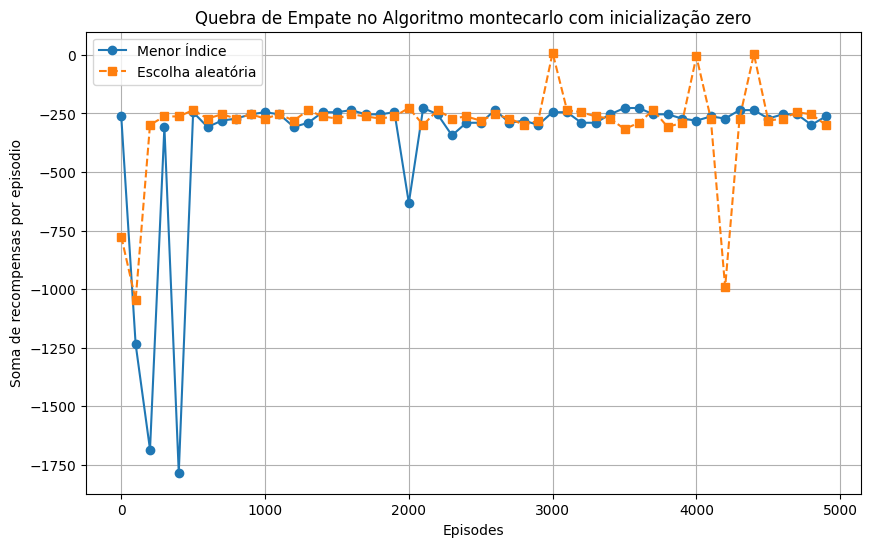

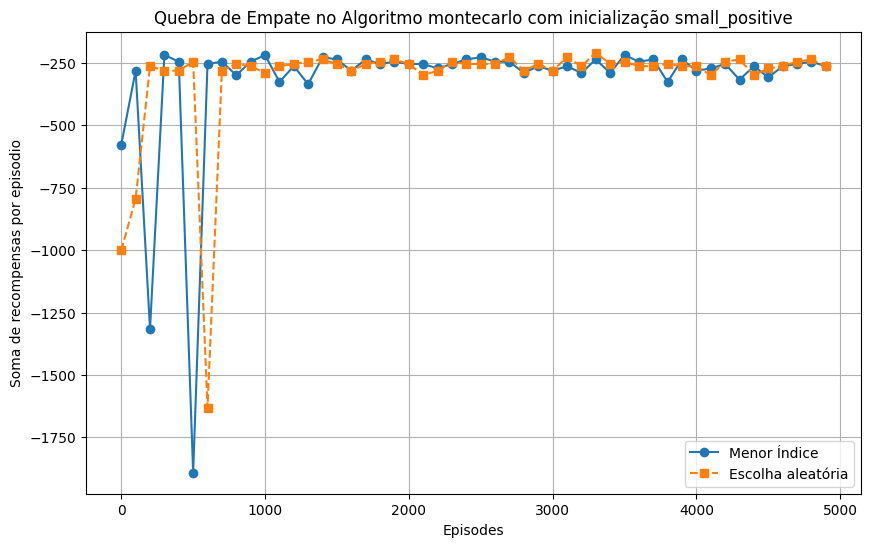

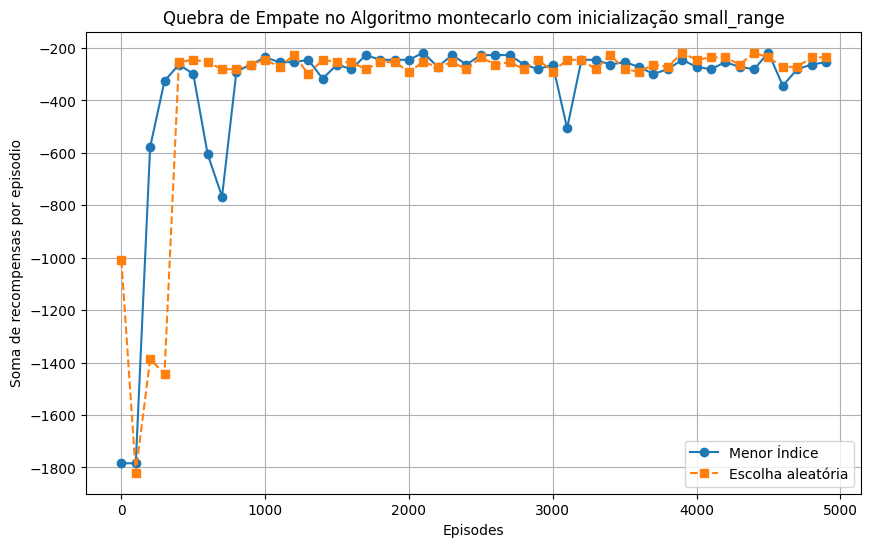

In [ ]:
#determinístico
env = gym.make("Taxi-v3")

run_experiment("montecarlo", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Determinístico: CliffWalking-v0

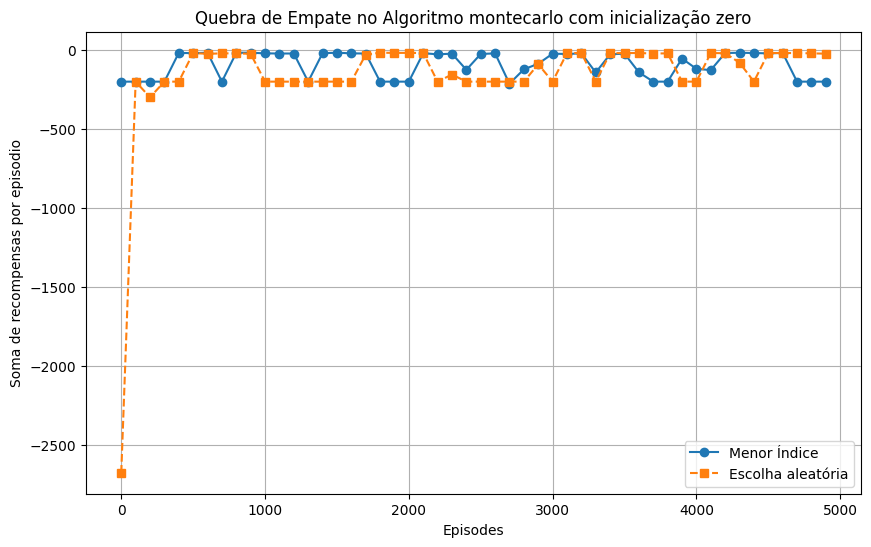

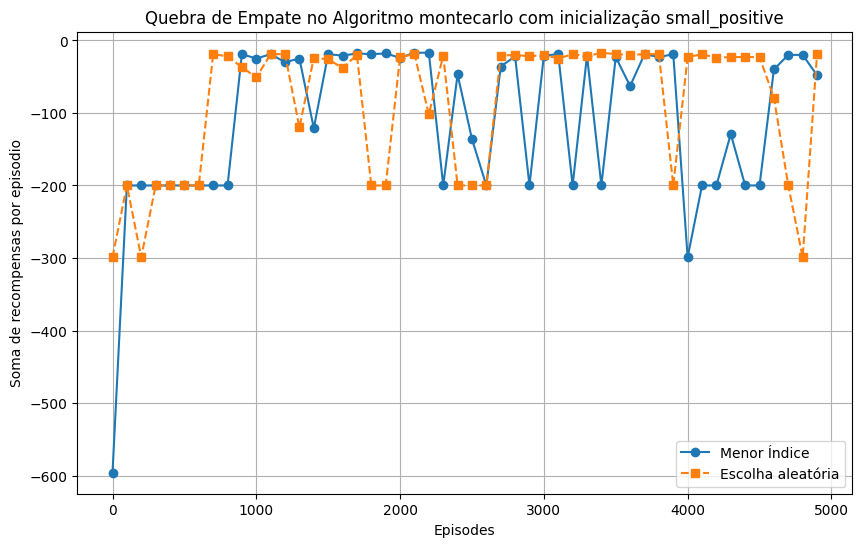

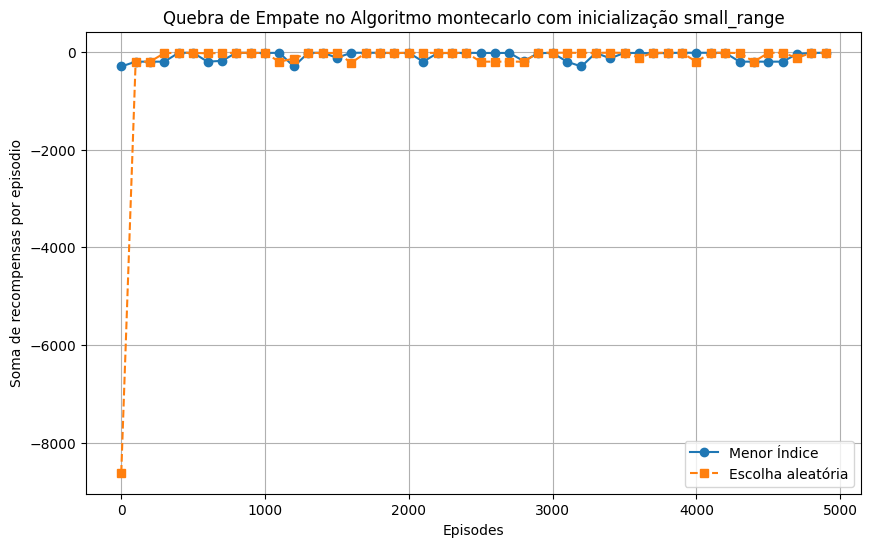

In [ ]:
# determinístico
env = gym.make("CliffWalking-v0")

run_experiment("montecarlo", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Estocástico: FrozenLake-v1

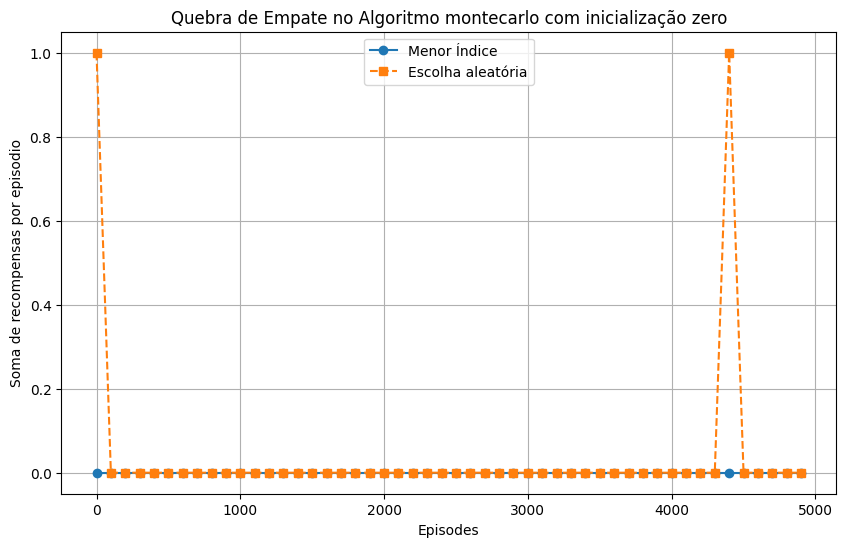

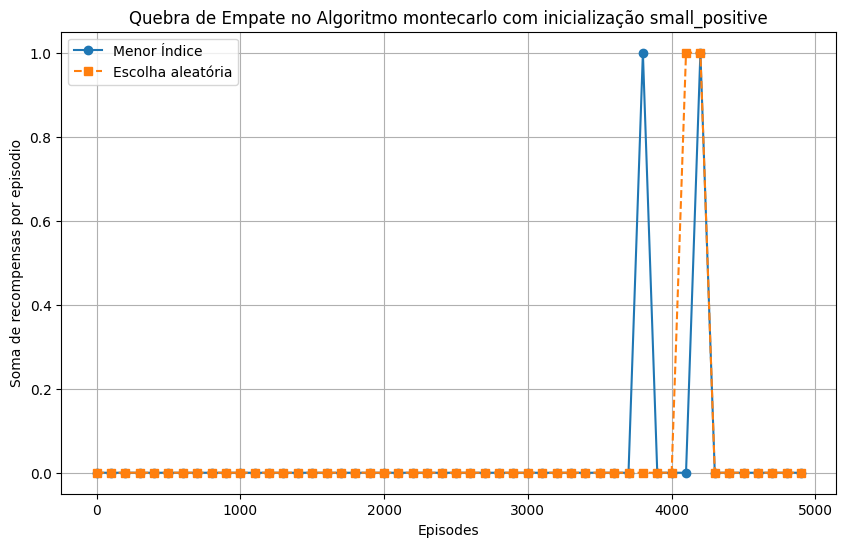

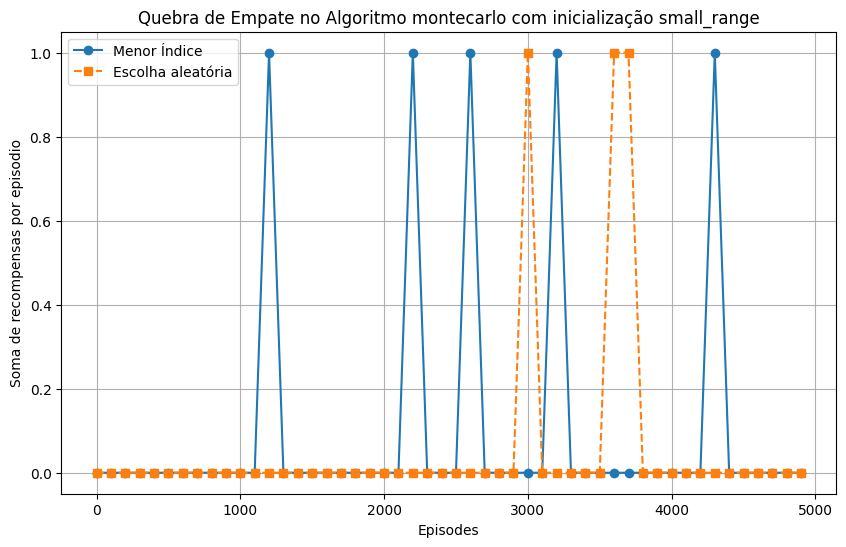

In [ ]:
#estocástico
env = gym.make("FrozenLake-v1", is_slippery=True)

run_experiment("montecarlo", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Estocástico: RaceTrack-v0

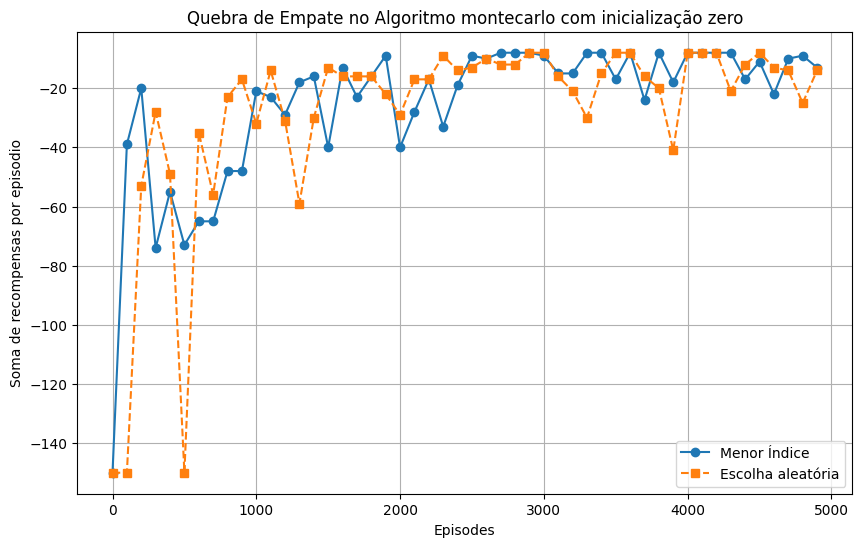

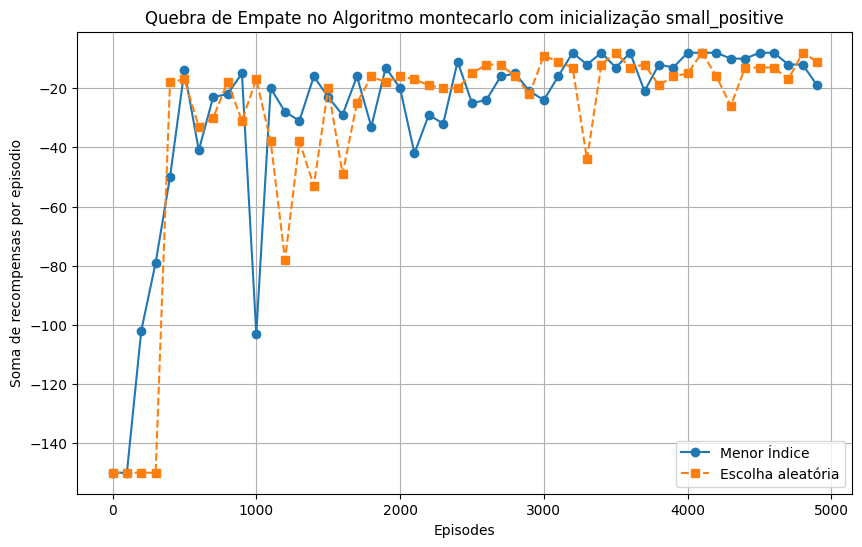

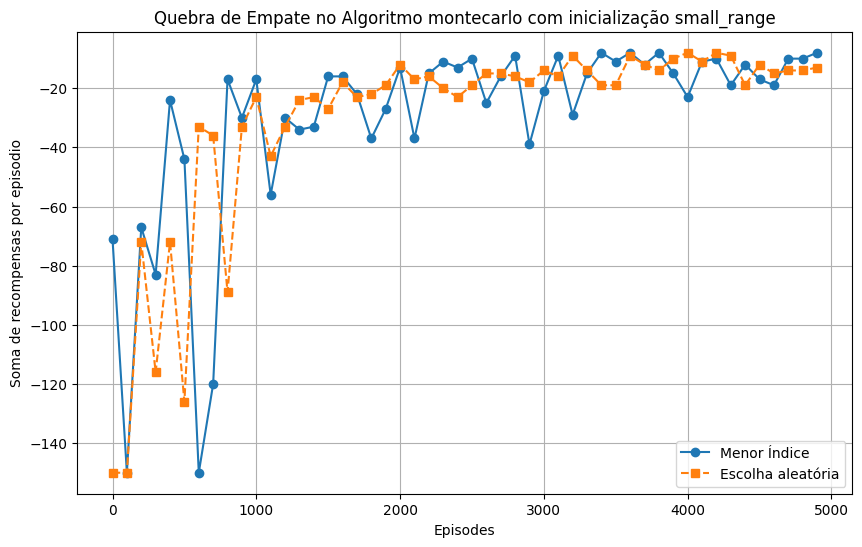

In [ ]:
#estocástico
env = gym.make("RaceTrack-v0")

run_experiment("montecarlo", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("montecarlo", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

###Q-Learning

####Determinístico: Taxi-v3

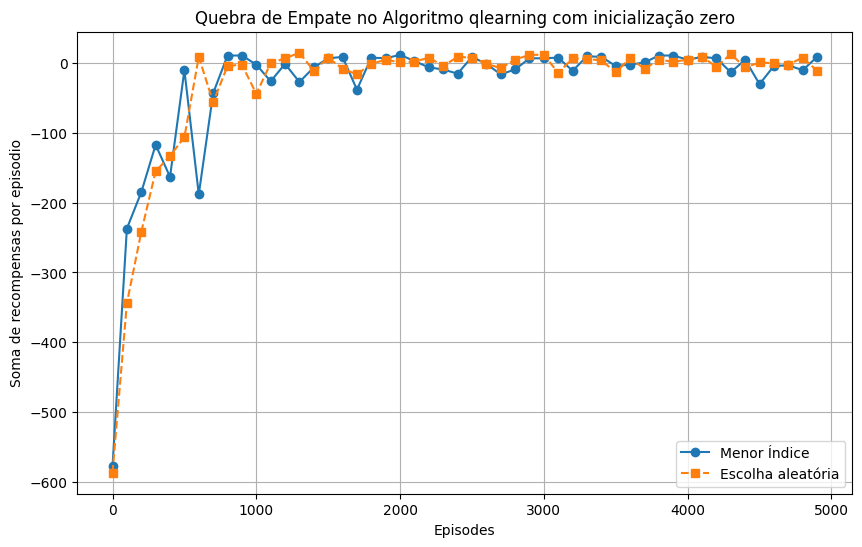

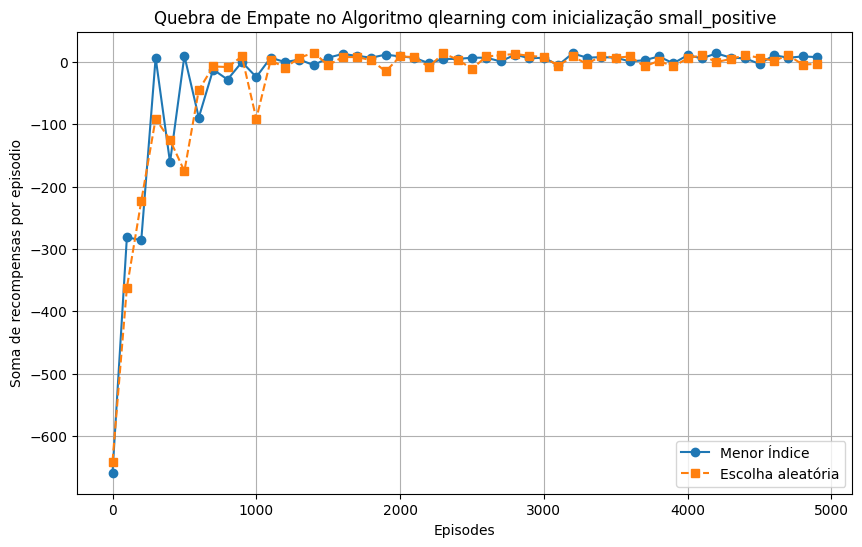

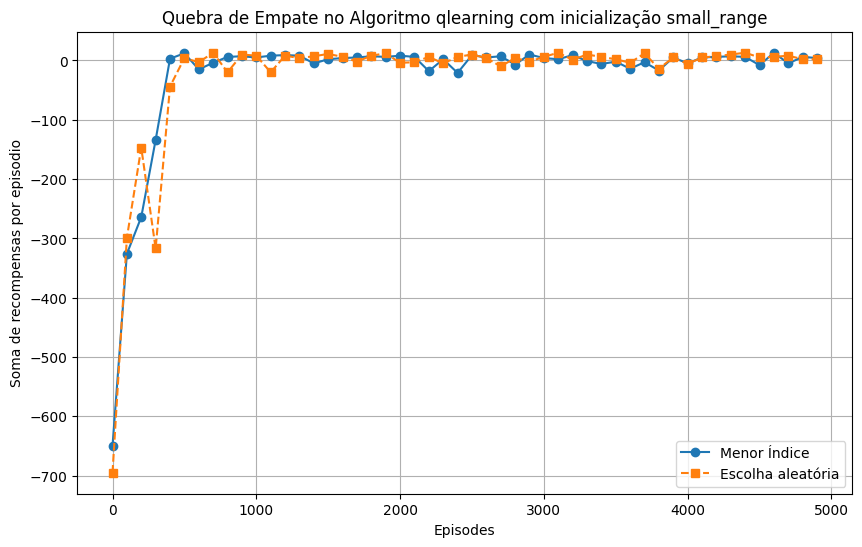

In [ ]:
#determinístico
env = gym.make("Taxi-v3")

run_experiment("qlearning", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Determinístico: CliffWalking-v0

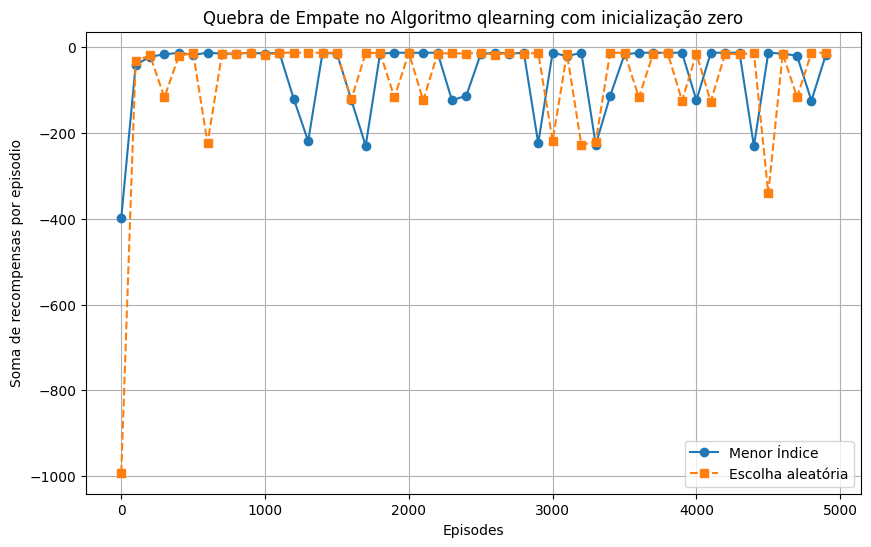

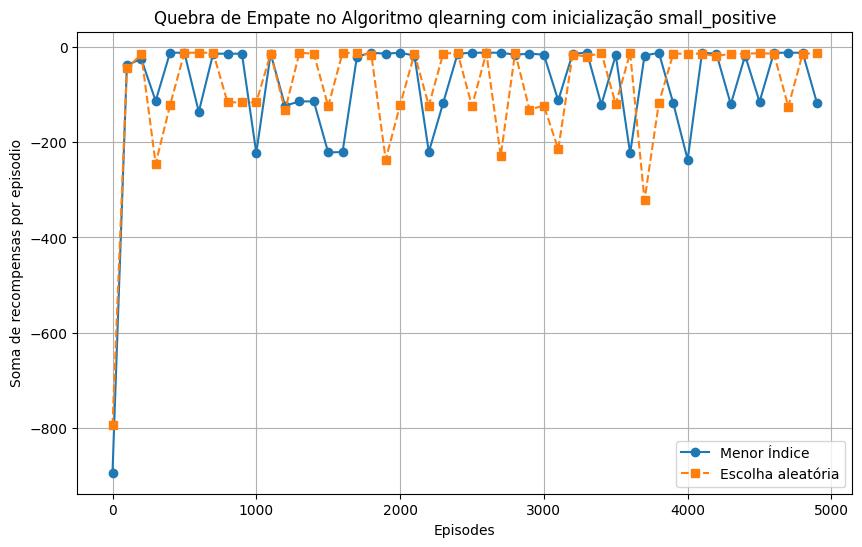

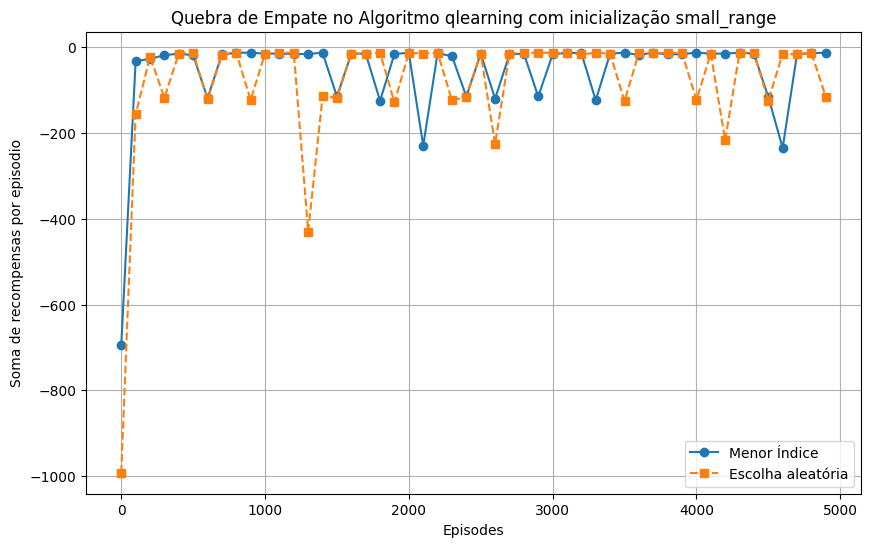

In [ ]:
# determinístico
env = gym.make("CliffWalking-v0")

run_experiment("qlearning", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Estocástico: FrozenLake-v1

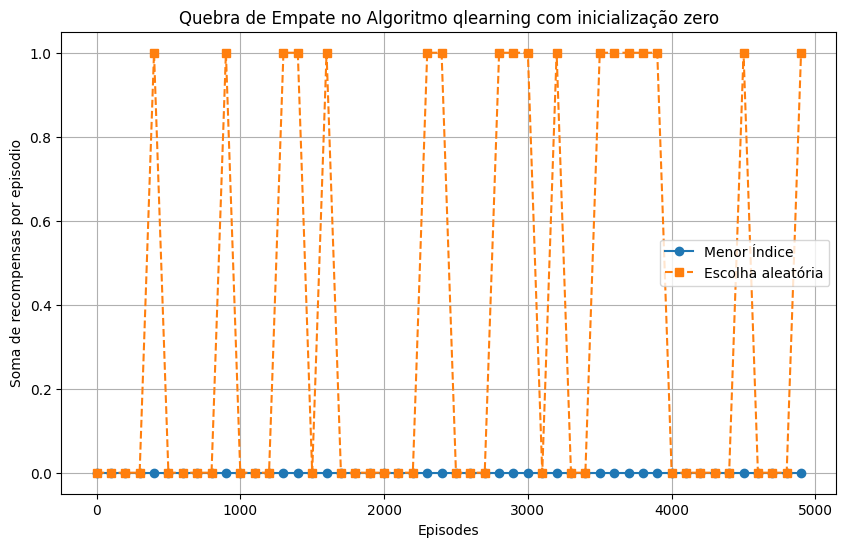

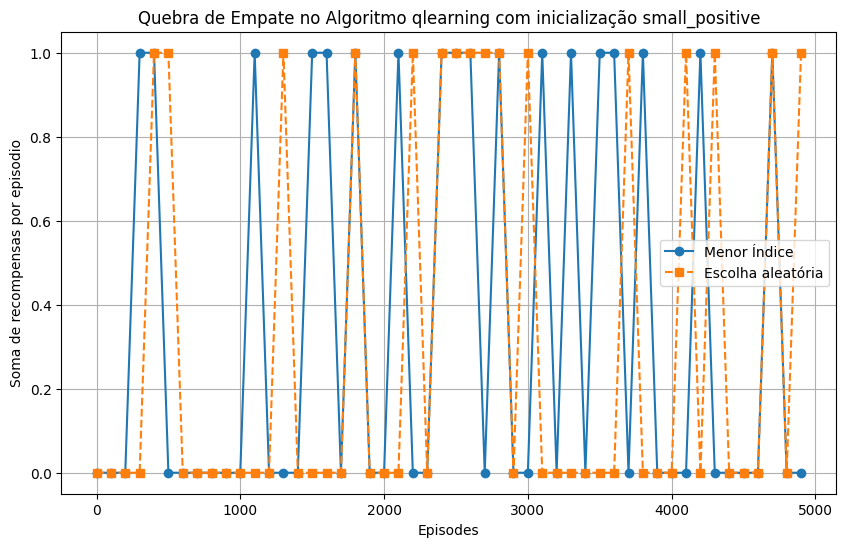

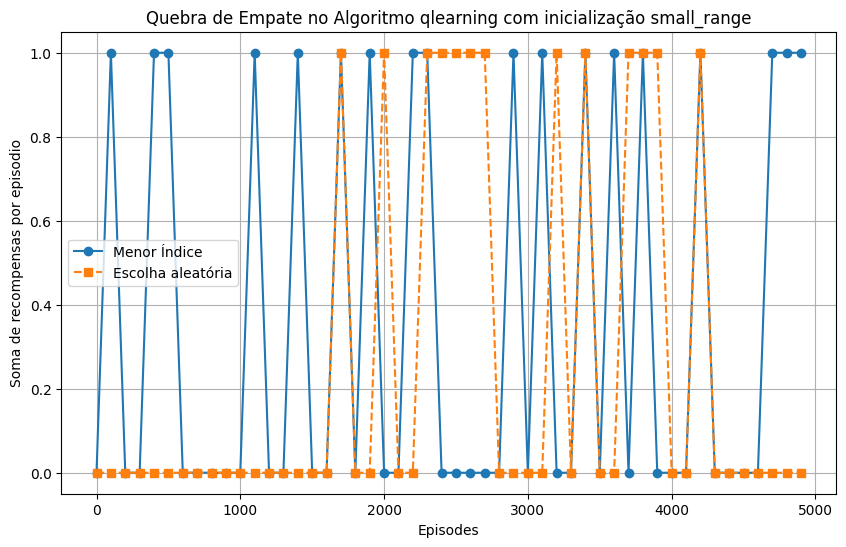

In [ ]:
#estocástico
env = gym.make("FrozenLake-v1", is_slippery=True)

run_experiment("qlearning", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Estocástico: RaceTrack-v0

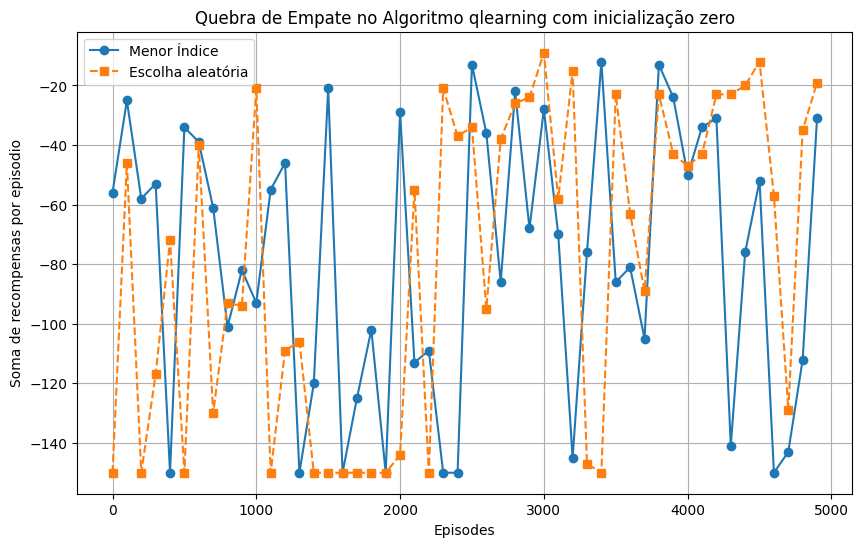

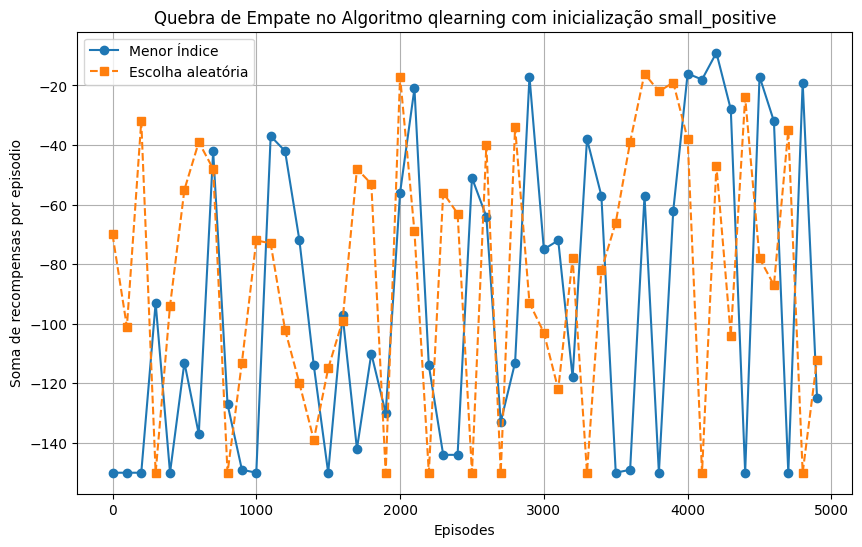

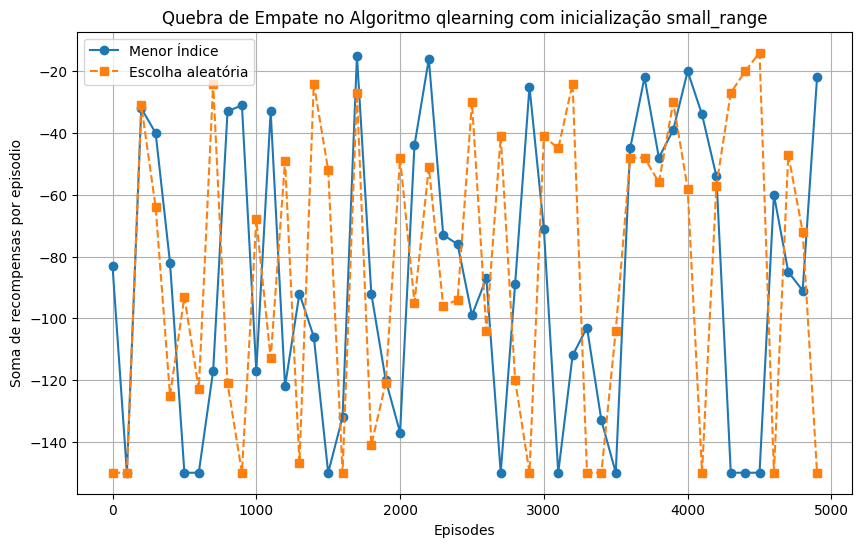

In [ ]:
#estocástico
env = gym.make("RaceTrack-v0")

run_experiment("qlearning", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("qlearning", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

###Exemplo de execução: Expected-Sarsa

####Determinístico: Taxi-v3

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/toy_text/taxi.py:318: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Taxi-v3", render_mode="rgb_array")
  gym.logger.warn(


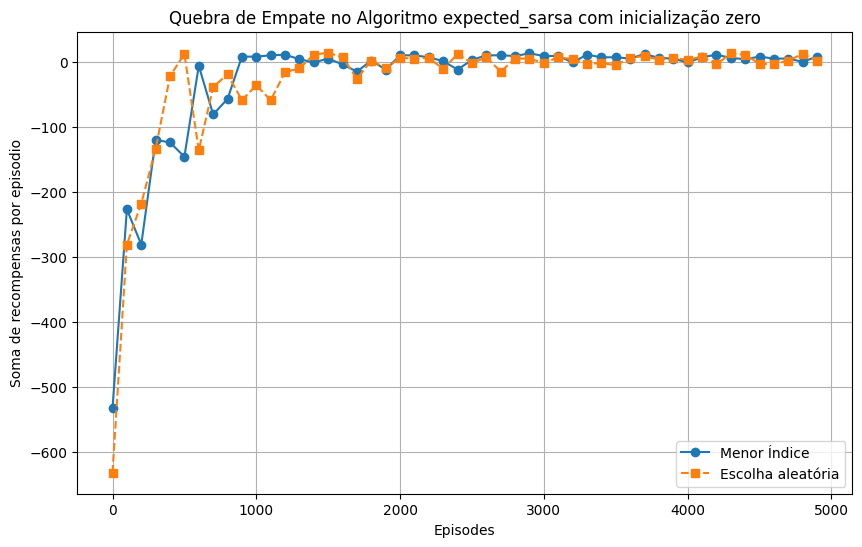

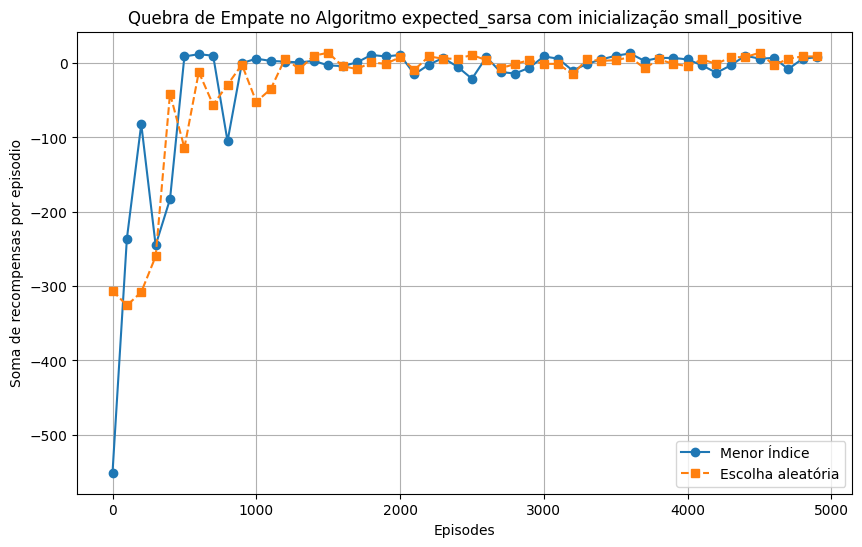

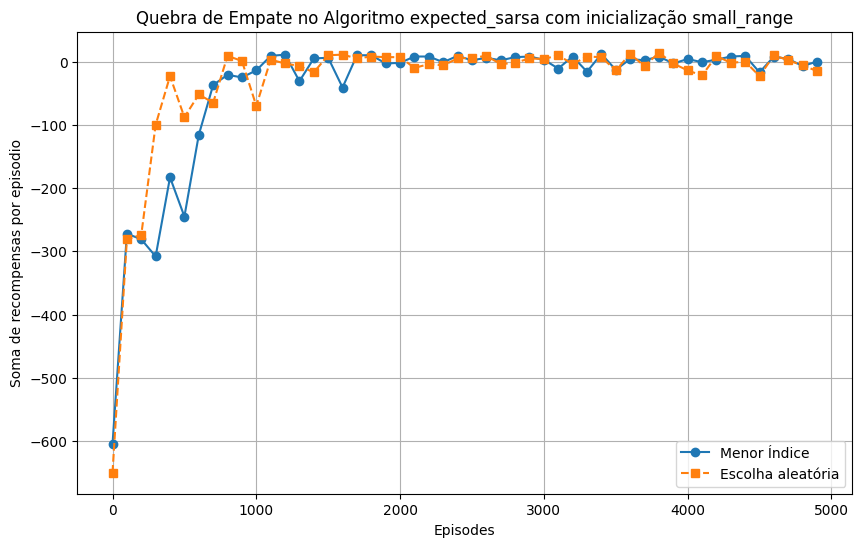

In [ ]:
#determinístico
env = gym.make("Taxi-v3")

run_experiment("expected_sarsa", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Determinístico: CliffWalking-v0

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/toy_text/cliffwalking.py:218: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CliffWalking-v0", render_mode="rgb_array")
  gym.logger.warn(


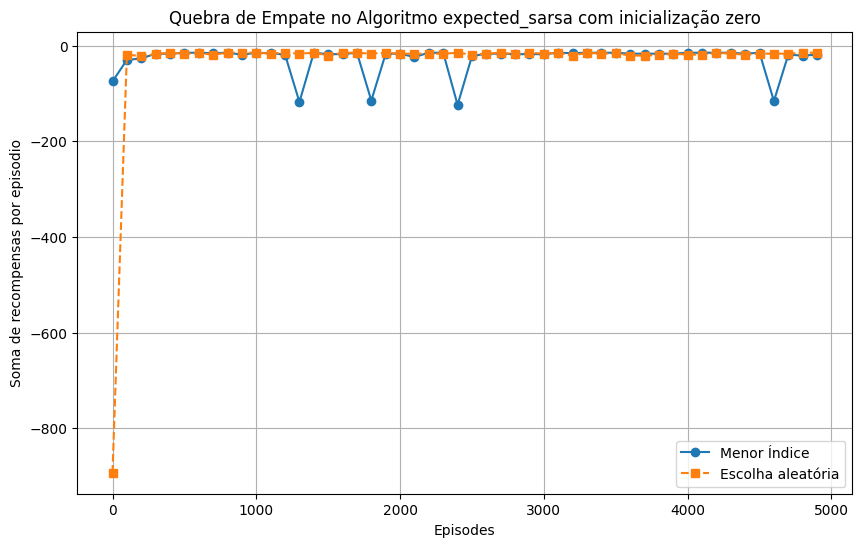

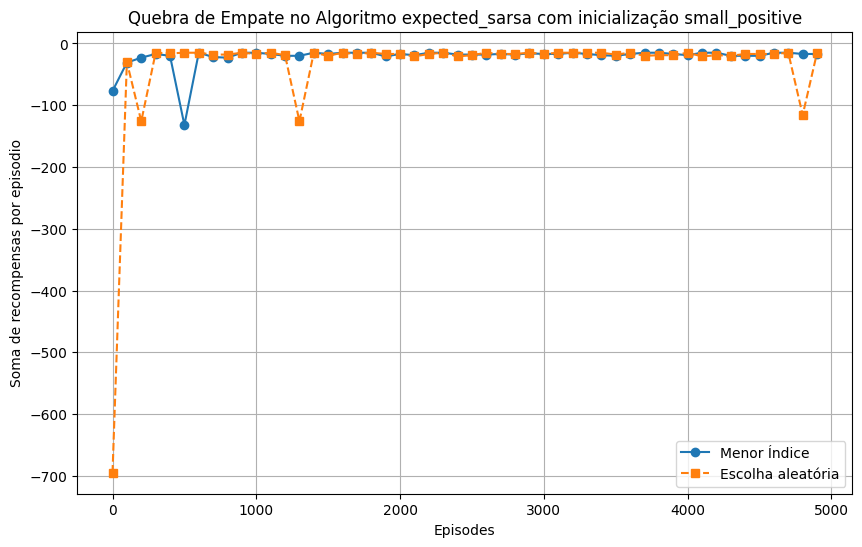

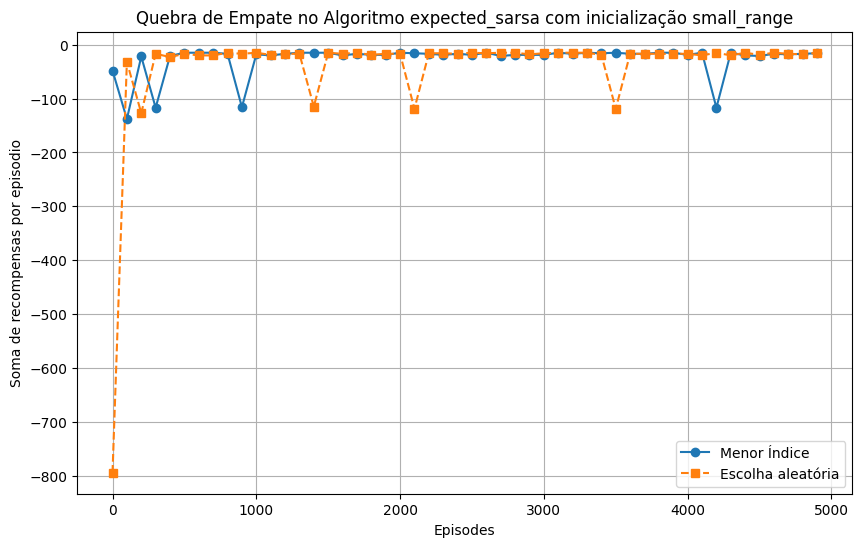

In [ ]:
# determinístico
env = gym.make("CliffWalking-v0")

run_experiment("expected_sarsa", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Estocástico: FrozenLake-v1

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/toy_text/frozen_lake.py:329: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


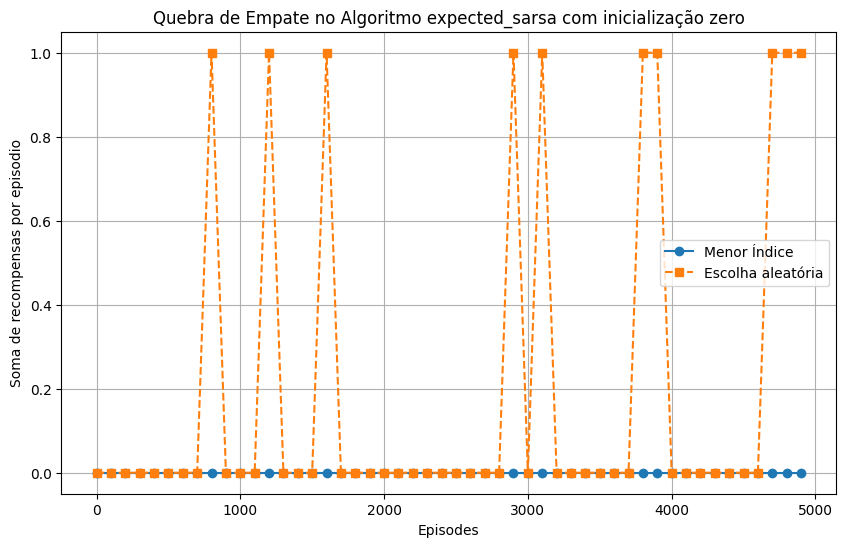

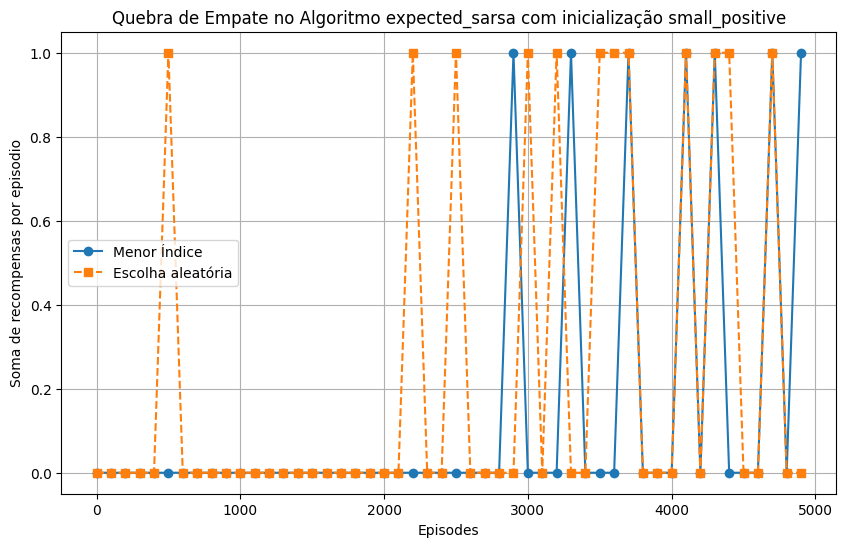

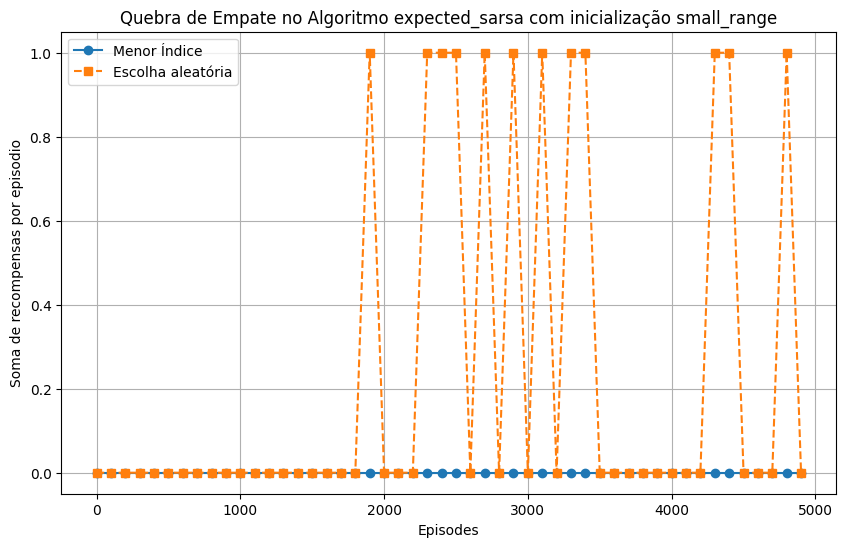

In [ ]:
#estocástico
env = gym.make("FrozenLake-v1", is_slippery=True)

run_experiment("expected_sarsa", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)

####Estocástico: RaceTrack-v0

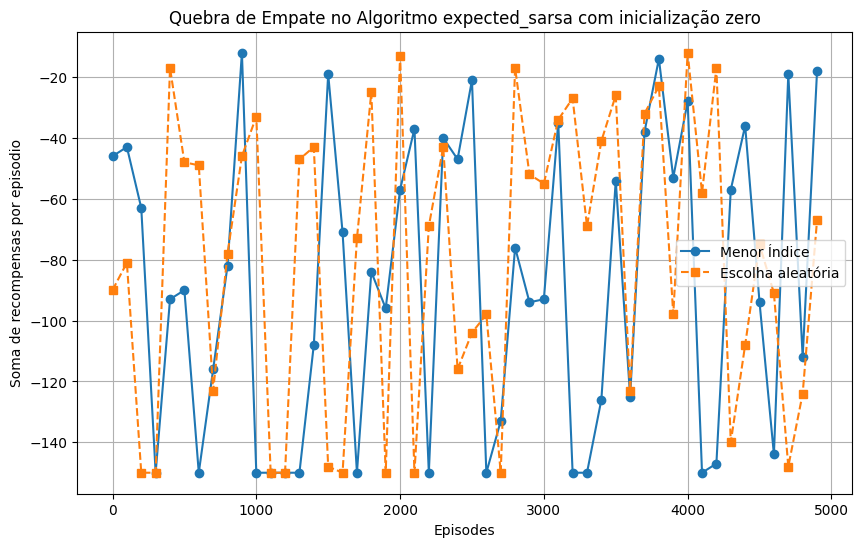

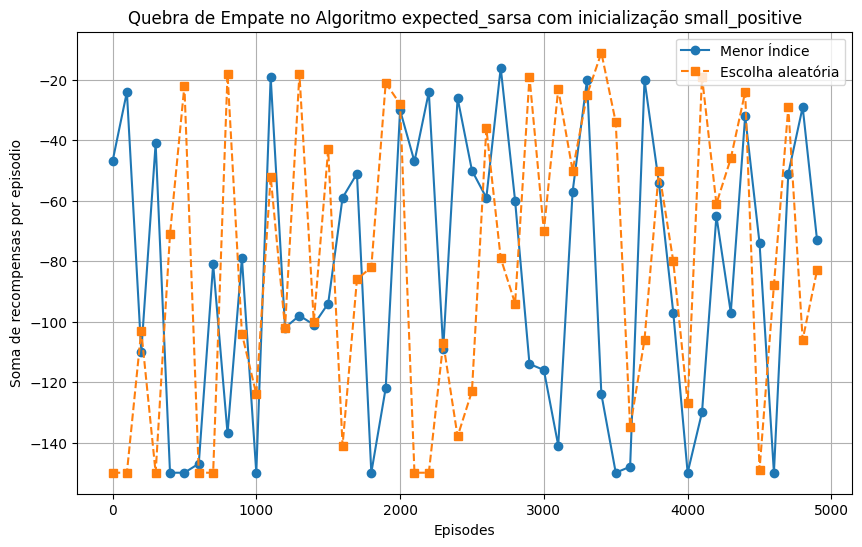

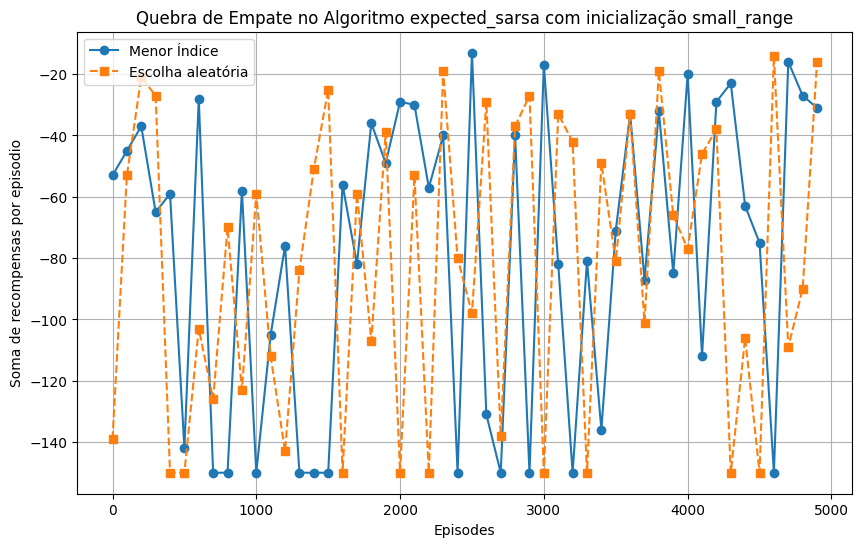

In [ ]:
#estocástico
env = gym.make("RaceTrack-v0")

run_experiment("expected_sarsa", env, init_type="zero", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_positive", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)
run_experiment("expected_sarsa", env, init_type="small_range", episodes=5000, lr=0.1, gamma=0.95, epsilon=0.1)